Opening and reading the file with customer subscription data and storing it into a list of lists

In [2]:
file_cust = open('subscriptionsdataFINAL.csv','r')
file_cust = file_cust.read().replace('\"','')
file_cust = file_cust.split('\n')

Further cleaning the data and getting a unique list of all the join dates sorted. Also converting the join dates/end date to a datetime format.

In [3]:
import datetime
from time import strptime
for j in range(1,len(file_cust)-1):
    file_cust[j] = file_cust[j].split(',')
    try:
        file_cust[j].append(datetime.datetime(int('20'+ file_cust[j][1].split('-')[1]),int(strptime(file_cust[j][1].split('-')[0],'%b').tm_mon),1))
        file_cust[j].append(datetime.datetime(int('20'+ file_cust[j][5].split('-')[1]),int(strptime(file_cust[j][5].split('-')[0],'%b').tm_mon),1))
    except:
        file_cust[j].append('#NA')

#fixing the header row
file_cust[0] = file_cust[0].split(',')
file_cust[0].append('Join_date_clean')
file_cust[0].append('End_date_clean')

get_months = []
for i in range(1,len(file_cust)-1):
    get_months.append(file_cust[i][1])
get_months = set(get_months)
def date_sort(row):
    return datetime.datetime(int('20'+ row.split('-')[1]),int(strptime(row.split('-')[0],'%b').tm_mon),1)
get_months = sorted(get_months,key = date_sort)



['May-09', 'Jun-09', 'Jul-09', 'Aug-09', 'Sep-09', 'Oct-09', 'Nov-09', 'Dec-09', 'Jan-10', 'Feb-10', 'Mar-10', 'Apr-10', 'May-10', 'Jun-10', 'Jul-10', 'Aug-10', 'Sep-10', 'Oct-10', 'Nov-10', 'Dec-10', 'Jan-11', 'Feb-11', 'Mar-11', 'Apr-11', 'May-11', 'Jun-11', 'Jul-11', 'Aug-11', 'Sep-11', 'Oct-11', 'Nov-11', 'Dec-11', 'Jan-12', 'Feb-12', 'Mar-12', 'Apr-12', 'May-12', 'Jun-12', 'Jul-12', 'Aug-12', 'Sep-12', 'Oct-12', 'Nov-12', 'Dec-12', 'Jan-13', 'Feb-13', 'Mar-13', 'Apr-13', 'May-13', 'Jun-13', 'Jul-13', 'Aug-13', 'Sep-13', 'Oct-13', 'Nov-13', 'Dec-13', 'Jan-14', 'Feb-14', 'Mar-14', 'Apr-14', 'May-14', 'Jun-14', 'Jul-14', 'Aug-14', 'Sep-14', 'Oct-14', 'Nov-14', 'Dec-14', 'Jan-15', 'Feb-15', 'Mar-15', 'Apr-15', 'May-15', 'Jun-15', 'Jul-15', 'Aug-15', 'Sep-15', 'Oct-15', 'Nov-15', 'Dec-15', 'Jan-16', 'Feb-16', 'Mar-16', 'Apr-16', 'May-16', 'Jun-16', 'Jul-16', 'Aug-16', 'Sep-16', 'Oct-16', 'Nov-16', 'Dec-16', 'Jan-17', 'Feb-17', 'Mar-17', 'Apr-17', 'May-17', 'Jun-17', 'Jul-17', 'Aug-17',

The below function takes as input a list of months and the subscription file as a list of lists. It then calculates the churn rate. Our definition of churn rate is (number of customers who left during the month)/(number of customers at start of month). If a customer was to join and leave in the same month then we also increase the numerator and denominator by 1 ie. they count as a churned customer.

In [4]:
def get_churn(get_months,file_cust):
    values = []
    output = []
    for i in get_months:
        current_date = datetime.datetime(int('20'+ i.split('-')[1]),int(strptime(i.split('-')[0],'%b').tm_mon),1)
        churn_customer = 0
        count_customer = 0
        for j in range(1,len(file_cust)-1):
            if current_date == file_cust[j][9]:
                churn_customer += 1
                count_customer += 1
            elif file_cust[j][8] < current_date and file_cust[j][9] == '#NA'or file_cust[j][8] < current_date and file_cust[j][9] > current_date:
                count_customer += 1
        if count_customer == 0:
            output.append([i,count_customer,churn_customer,'#NA'])
            values.append('#NA')
        else:
            output.append([i,count_customer,churn_customer,churn_customer/count_customer])
            values.append(churn_customer/count_customer)
    return output,values

The other metric we are analysing is the average total revenue per gym franchise. Since the number of gym franchises has been increasing over time, we cannot use total revenue as a metric. Instead we are standardising this number by dividing the total revenue by the number of gyms that was open at a point in time. We will call this metric, standardised revenue.

In the below function we are opening and combining the visitation data, we are also opening the subscription data and loading it into a dataframe.

In [5]:
import pandas as pd
df1 = pd.read_csv('visitationdataPART1.csv')
df2 = pd.read_csv('visitationdataPART2.csv')
visit_db = pd.concat([df1, df2], axis=0)

In [6]:
cust = pd.read_csv('subscriptionsdataFINAL.csv')

In the below block of code we are cleaning and converting the data types of the columns, renaming columns and removing any unnecessary columns.

In [7]:
visit_db['timestamp'] = visit_db['visitdate']+' '+visit_db['TimeofVisit']
visit_db['timestamp'] = pd.to_datetime(visit_db['timestamp'])
visit_db['is_peak'] = [1 if x == 'TRUE' else 0 for x in visit_db['peakvisits']]
visit_db = visit_db.drop(columns=['peakvisits', 'visitdate', 'TimeofVisit'])
visit_db = visit_db.rename(columns={"CustomerID": "id"})

,id,timestamp,is_peak
0,126444,2009-05-01 05:45:00,0
1,456610,2009-05-01 05:45:00,0


In the below block of code we are first joining the customer and visitation data so that we have a column showing which gym franchise each transaction belongs to. Then we are performing a group by to see how many customers per gym in each month. We then fix up the timestamp format to be aligned with the subscriptionsdataFINAL.csv file. Finally we perform another group by to see how many gyms are open during each month of each year.

In [8]:
merged_data=pd.merge(cust[['Club','CustomerID']], visit_db, how='inner', left_on='CustomerID', right_on='id')
club_time_grouped = merged_data.groupby(['Club',pd.Grouper(key='timestamp',freq='M')]).count().reset_index()

timestamps = club_time_grouped['timestamp']
timestmamps_month = []
for j in timestamps:
    timestmamps_month.append(j.strftime('%b') + '-' + str(j.year)[2:4] )
club_time_grouped['timestamp_reformat'] = timestmamps_month
no_stores = club_time_grouped[["timestamp_reformat","id"]].groupby(['timestamp_reformat']).count().reset_index()

,timestamp_reformat,id
0,Apr-10,4
1,Apr-11,8
2,Apr-12,11
3,Apr-13,15
4,Apr-14,18



The below block of code can be used to get the average total revenue for each month. That is (the total revenue for month)/(total number of stores open during that month) we will cal this measure standardised revenue. An assumption we have made is that the customer will pay the full monthly fee in the month they join and the month they leave. We haven’t got customer joining/leaving information at the date level but instead at the month level.  


In [9]:
def get_visit_counts(merged_data,no_stores,get_months,file_cust):
    
    def get_join_revenue(get_months,file_cust):
        values = []
        for i in get_months:
            current_date = datetime.datetime(int('20'+ i.split('-')[1]),int(strptime(i.split('-')[0],'%b').tm_mon),1)
            monthly_joining_revenue = 0
            for j in range(1,len(file_cust)-1):
                if current_date.strftime('%Y') in ['2016','2018','2017']:
                    if file_cust[j][8] <= current_date and file_cust[j][9] == '#NA'or file_cust[j][8] <= current_date and file_cust[j][9] >= current_date:
                        if file_cust[j][4] == 'Standard':
                            monthly_joining_revenue += 26.99
                        elif file_cust[j][4] == 'Flexible':
                            monthly_joining_revenue += 30.99
                        if file_cust[j][8] == current_date:
                            monthly_joining_revenue += 5   
                else:
                    if file_cust[j][8] <= current_date and file_cust[j][9] == '#NA'or file_cust[j][8] <= current_date and file_cust[j][9] >= current_date:
                        if file_cust[j][4] == 'Standard':
                            monthly_joining_revenue += 20.99
                        elif file_cust[j][4] == 'Flexible':
                            monthly_joining_revenue += 25.99
                        if file_cust[j][8] == current_date:
                            monthly_joining_revenue += 5

            values.append([i,monthly_joining_revenue])
        return values

    print('hi')
    grouped_data = merged_data.groupby([pd.Grouper(key='timestamp',freq='M')]).count().reset_index()
    timestamps = grouped_data['timestamp']
    timestmamps_month = []
    for j in timestamps:
        timestmamps_month.append(j.strftime('%b') + '-' + str(j.year)[2:4] )
    grouped_data['timestamp_reformat'] = timestmamps_month
    grouped_data = grouped_data[["timestamp_reformat","Club"]]
    grouped_data["Club"] = grouped_data["Club"] * 6
    grouped_data.columns = ["timestamp_reformat","visit_revenue"]
    values = get_join_revenue(get_months,file_cust)
    grouped_data_list = grouped_data.values.tolist()
    grouped_store_count = no_stores.values.tolist()
    for j in values:
        for k in grouped_data_list:
            if j[0] == k[0]:
                j[1] += k[1]
        for k in grouped_store_count:
            if j[0] == k[0]:
                j[1] =  j[1]/k[1]
    
    clean_values = []
    for j in values:
        clean_values.append(j[1])
    return clean_values
            

## What happened when the prices increased

The first hypothesis is that the churn levels would have increase prior to the increase in the price, where customers had the option of leaving but then settled after. In addition to this the standardised revenue would have initially decreased and then continued at the decreased rate. The below code uses the functions that get standardised revenue and churn rate on a monthly basis and then plots the two graphs.

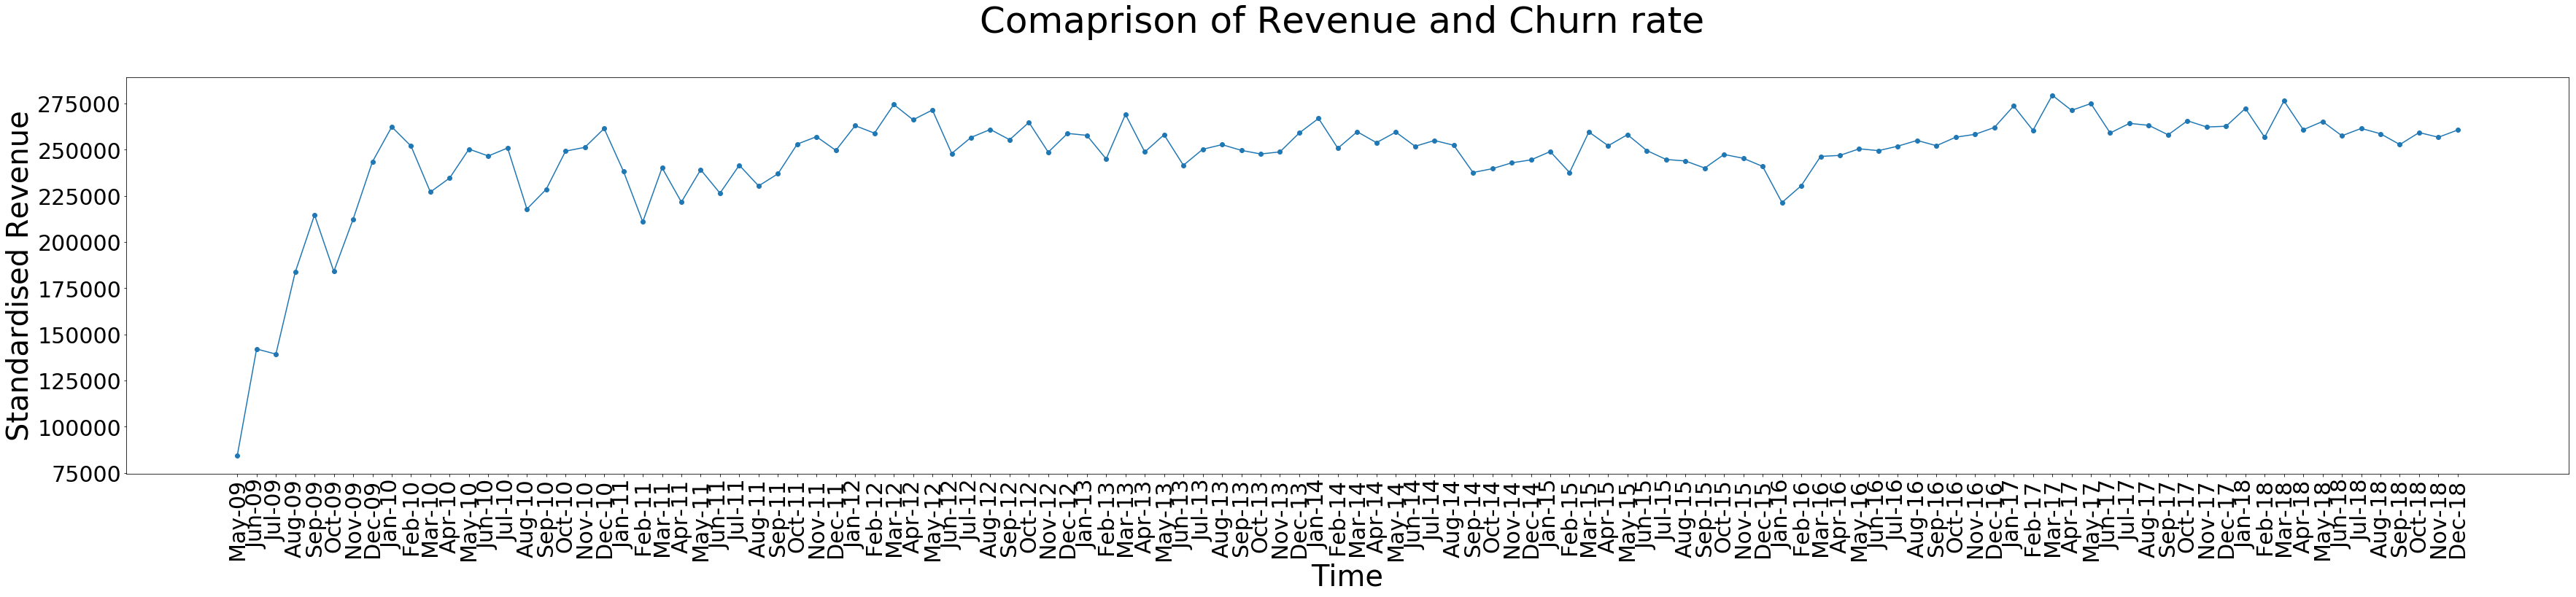

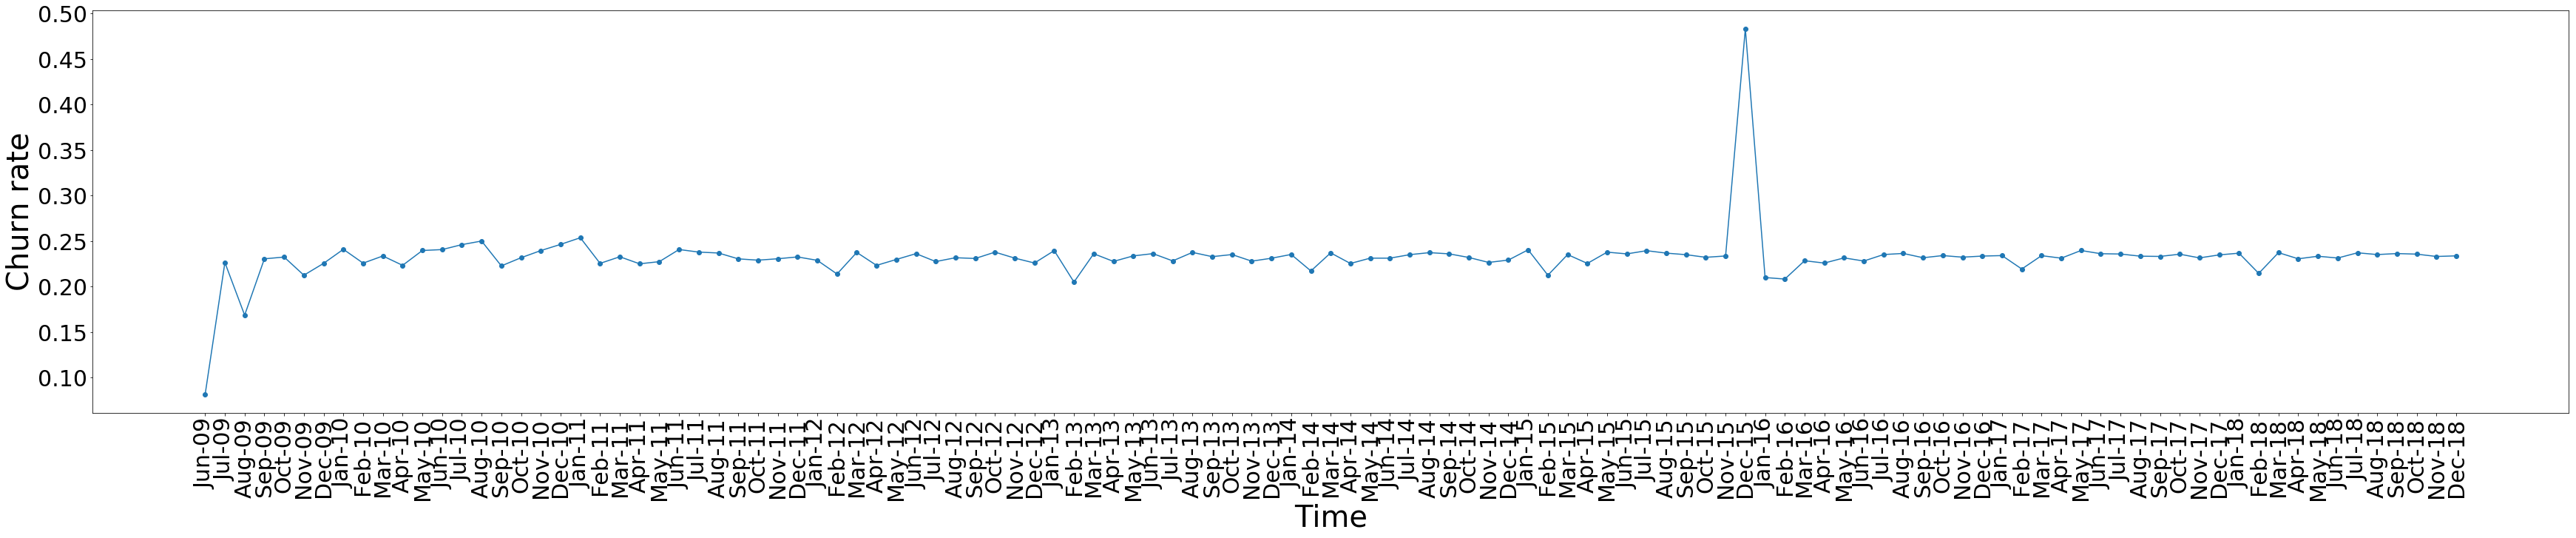

In [45]:
'''total_avg_revenue = get_visit_counts(merged_data,no_stores,get_months,file_cust)   
output,total_churn = get_churn(get_months,file_cust)
total_churn = total_churn[1:len(total_churn)]
mon_year = get_months[1:len(get_months)]'''


import matplotlib.pyplot as plt


plt.figure(figsize=(60,10))
plt.plot(get_months,total_avg_revenue,'o-')
plt.xticks(rotation=90)
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
plt.xlabel('Time',fontsize = 40)
plt.ylabel('Standardised Revenue',fontsize = 40)
plt.title('Comaprison of Revenue and Churn rate \n', fontsize=50)
plt.show()


plt.figure(figsize=(60,10))
plt.plot(mon_year,total_churn,'o-')
plt.xticks(rotation=90)
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel('Time',fontsize = 40)
plt.ylabel('Churn rate',fontsize = 40)
plt.show()


From the above graph we can see that the first part of the hypothesis is correct, there is a huge spike in churn right before Jan 2016, which is the period customers got to leave. In addition to this we can see a significant drop in standardised revenue right after the spike. However the revenue does increase again to the amount it was before the price change. In addition to this the churn rate also restores to a similar level. So overall the price change has not had a negative impact on the business. But growth has not been at the same level as when the Gym first opened. It is understood the business would like to keep growing but it may not be practical to keep growing at the same rate forever. 

The second hypothesis is that different groups of customers would have reacted to the price hike in different ways. Knowledge of this may allow us to either offer a new pricing strategy or other benefits to decrease the churn rate of a paticular group. The first group we will be exploring is Male vs Female

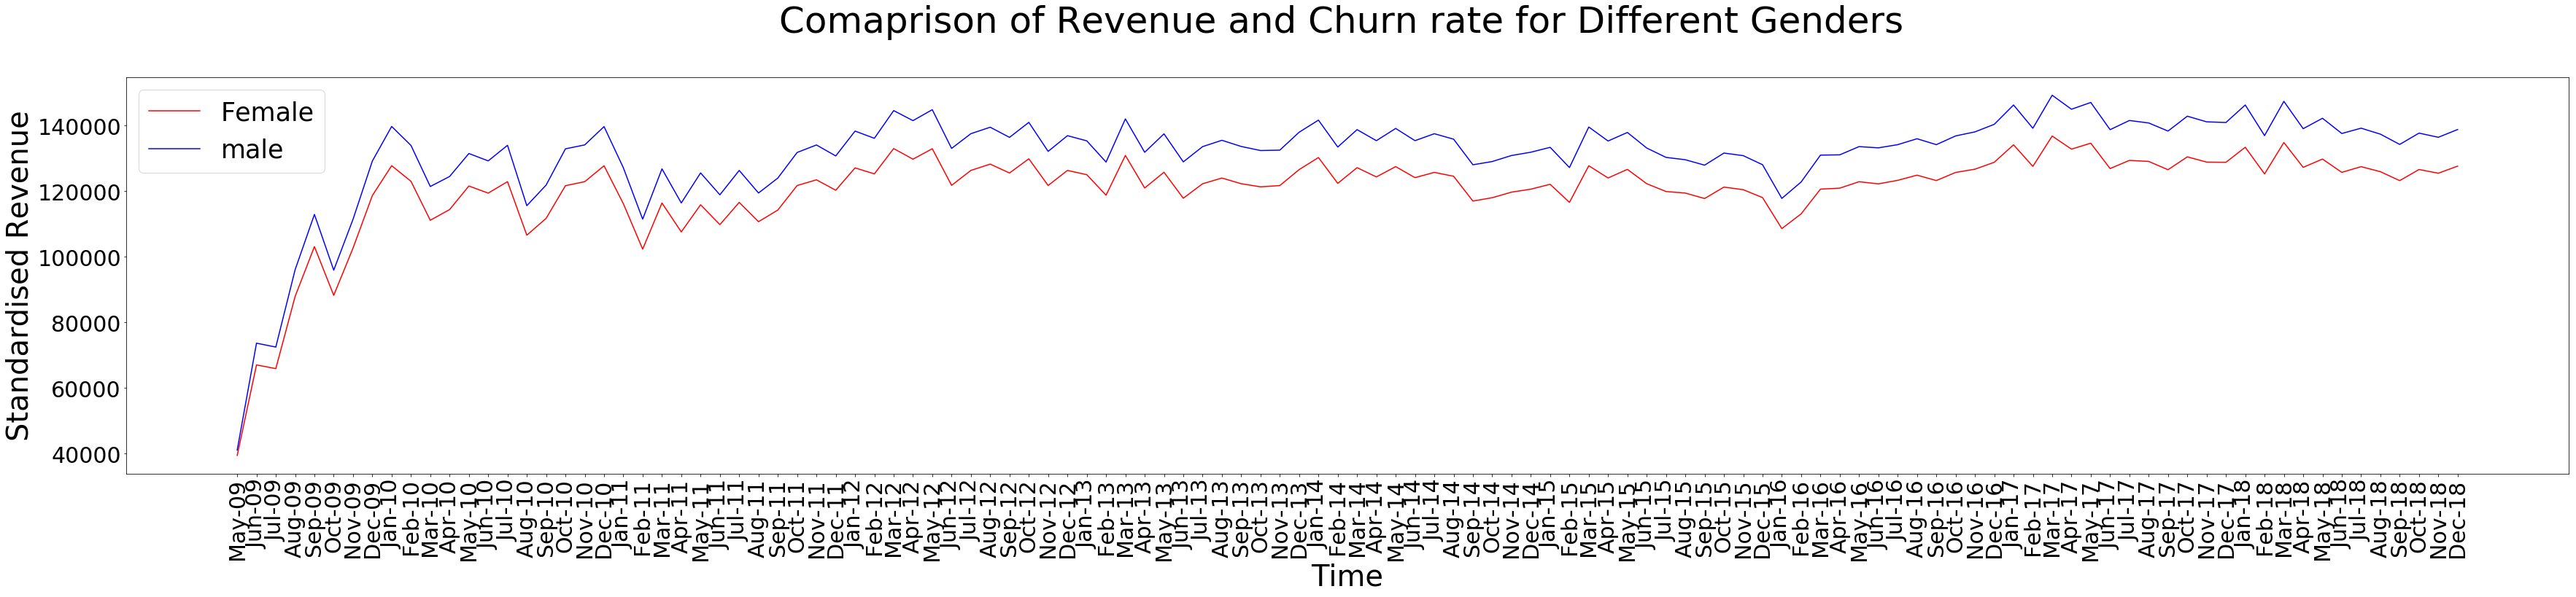

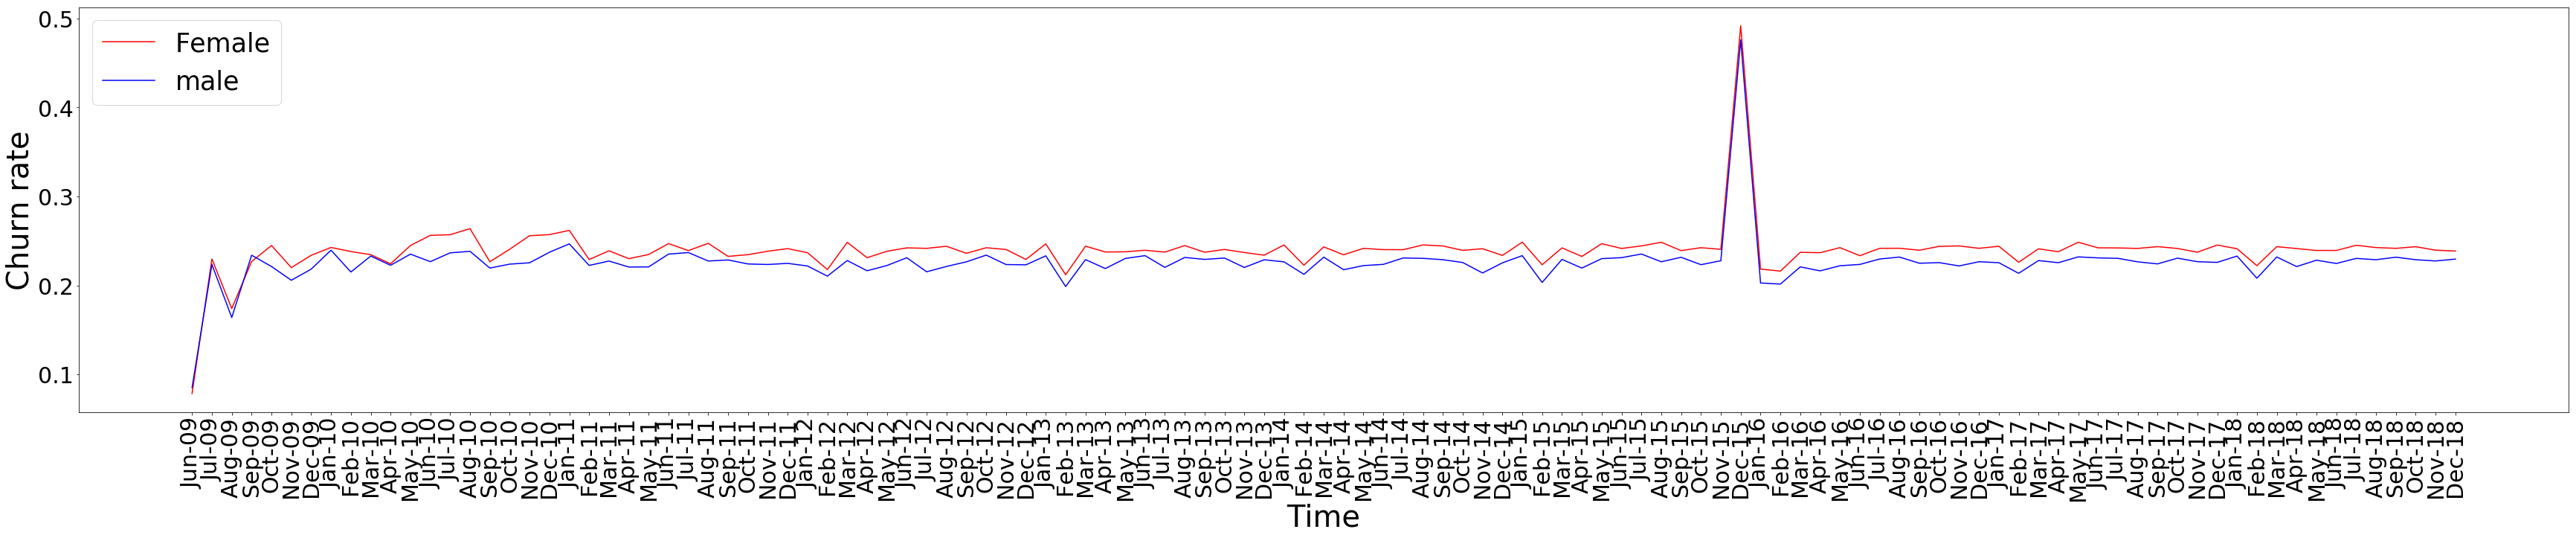

In [37]:
male_data = []
female_data = []
male_data.append(file_cust[0])
female_data.append(file_cust[0])
for i in range(1,len(file_cust)-1):
    if file_cust[i][3] == 'Male':
        male_data.append(file_cust[i])
    if file_cust[i][3] == 'Female':
        female_data.append(file_cust[i])

    
male_df = pd.DataFrame(male_data[1:len(male_data)], columns = male_data[0])
female_df = pd.DataFrame(male_data[1:len(female_data)], columns = female_data[0])

male_df['CustomerID'] = male_df['CustomerID'].astype(str).astype(int)

female_df['CustomerID'] = female_df['CustomerID'].astype(str).astype(int)

male_visits = pd.merge(male_df[['Club','CustomerID']], visit_db, how='inner', left_on='CustomerID', right_on='id')
female_visits = pd.merge(female_df[['Club','CustomerID']], visit_db, how='inner', left_on='CustomerID', right_on='id')

output_male,values_male = get_churn(get_months,male_data)
output_female,values_female = get_churn(get_months,female_data)
values_male = values_male[1:len(values_male)]
values_female = values_female[1:len(values_female)]

total_avg_revenue_male = get_visit_counts(male_visits,no_stores,get_months,male_data)   
total_avg_revenue_female = get_visit_counts(female_visits,no_stores,get_months,female_data) 

                                             
                         
plt.figure(figsize=(60,10))
plt.plot(get_months,total_avg_revenue_female,color="red", label='Female')
plt.plot(get_months,total_avg_revenue_male,color="blue", label='male')
plt.xticks(rotation=90)
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.legend(loc='upper left',prop={'size': 35})
plt.xlabel('Time',fontsize = 40)
plt.ylabel('Churn rate',fontsize = 40)
plt.title('Comaprison of Revenue and Churn rate for Different Genders \n', fontsize=50)
plt.ylabel('Standardised Revenue',fontsize = 40)
plt.show()


plt.figure(figsize=(60,10))
plt.plot(mon_year,values_female,color="red",label='Female')
plt.plot(mon_year,values_male,color="blue",label='male')
plt.xticks(rotation=90)
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
plt.legend(loc='upper left',prop={'size': 35})
plt.xlabel('Time',fontsize = 40)
plt.ylabel('Churn rate',fontsize = 40)
plt.show()



From the above graphs we can see that females have consistently had a higher churn rate and have contributed less towards revenue. The reason for the higher churn rate could be that personal trainers/dietitians at the gym are predominantly male and offer male specific advice/tips. The gym could offer a free diet/training plan advice as a group session for all women once a month where they get advice specific to female body types. This could help them make more progress and hence gain motivation and not drop their gym subscription.

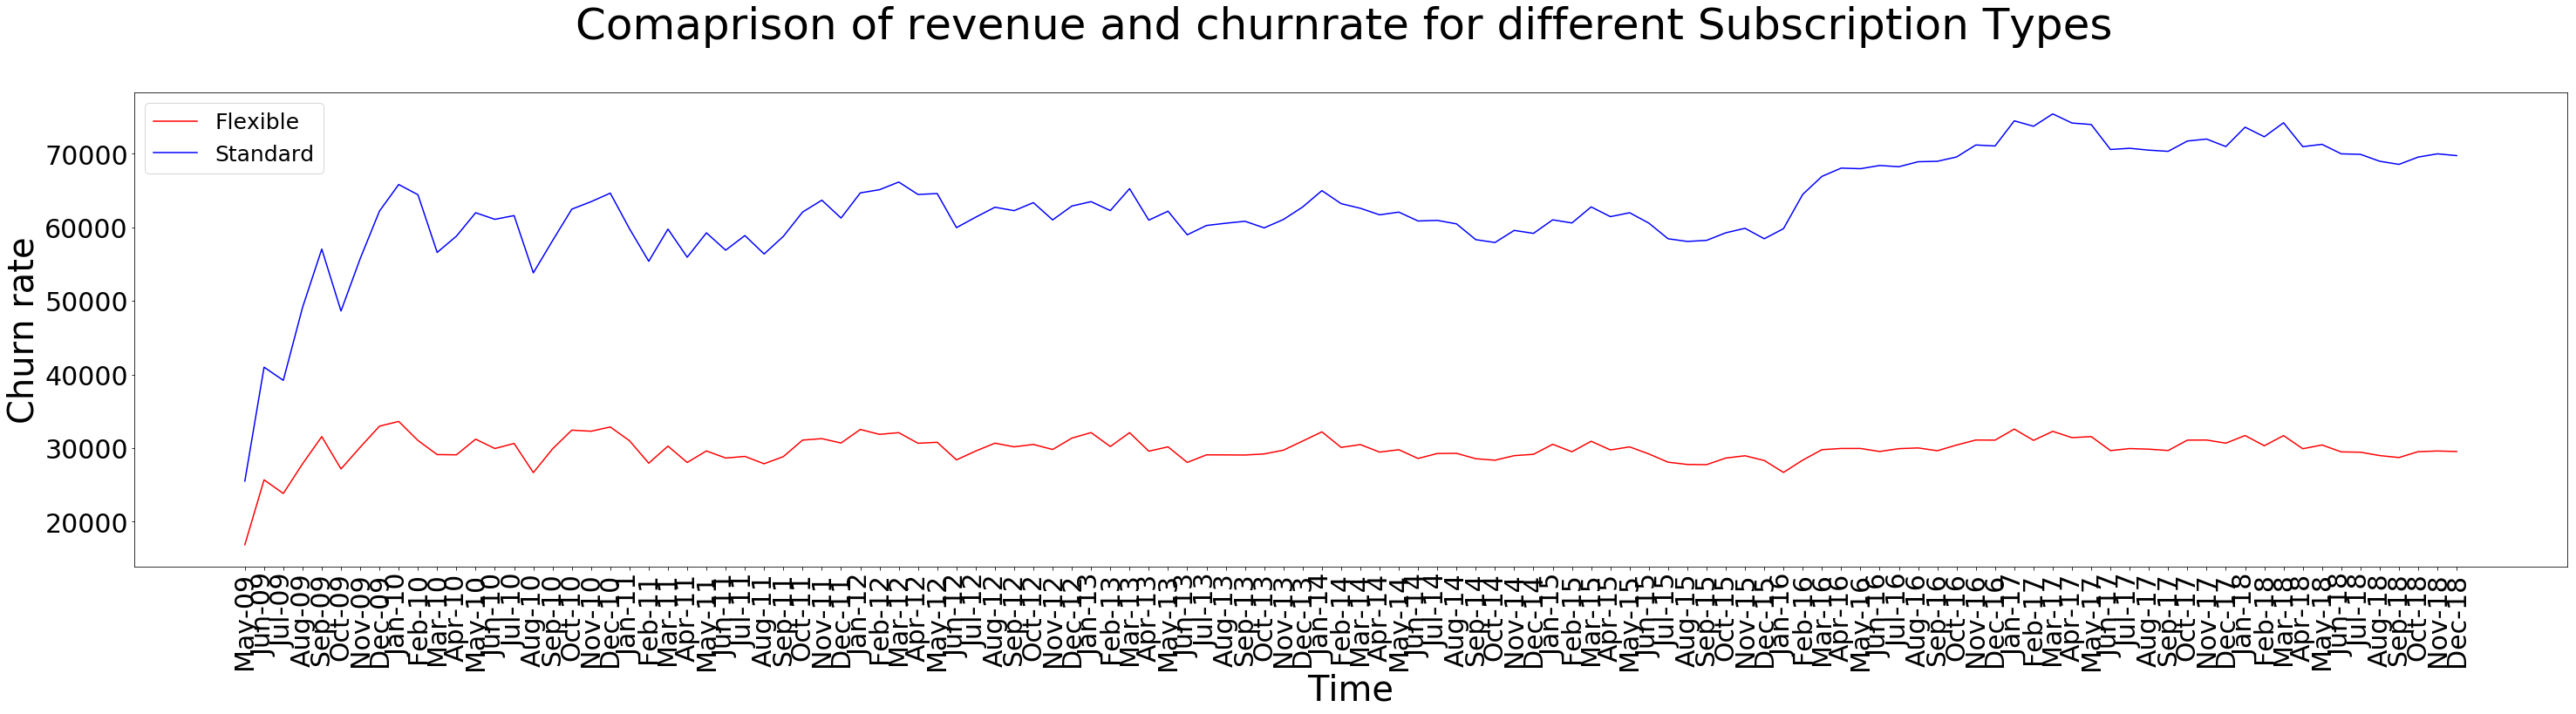

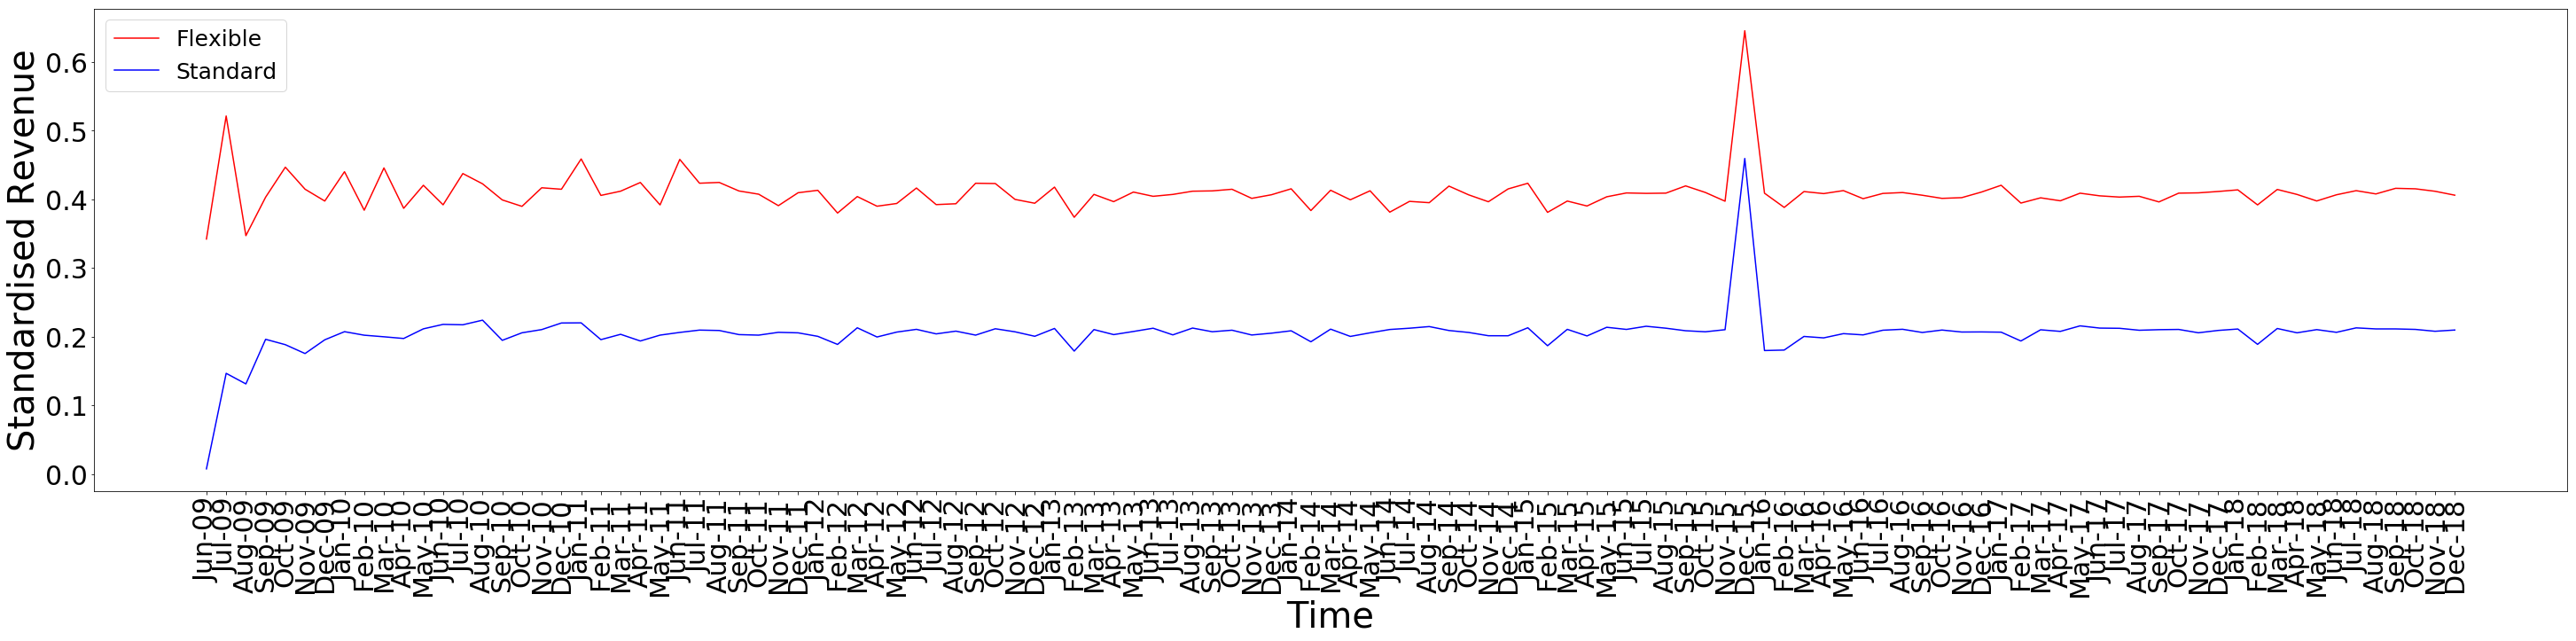

In [35]:
Flexible_data = []
Standard_data = []
Flexible_data.append(file_cust[0])
Standard_data.append(file_cust[0])
for i in range(1,len(file_cust)-1):
    if file_cust[i][4] == 'Flexible':
        Flexible_data.append(file_cust[i])
    if file_cust[i][4] == 'Standard':
        Standard_data.append(file_cust[i])
print('here')

    
Flexible_df = pd.DataFrame(Flexible_data[1:len(Flexible_data)], columns = Flexible_data[0])
Standard_df = pd.DataFrame(Flexible_data[1:len(Standard_data)], columns = Standard_data[0])

Flexible_df['CustomerID'] = Flexible_df['CustomerID'].astype(str).astype(int)

Standard_df['CustomerID'] = Standard_df['CustomerID'].astype(str).astype(int)

print('here')
Flexible_visits = pd.merge(Flexible_df[['Club','CustomerID']], visit_db, how='inner', left_on='CustomerID', right_on='id')
Standard_visits = pd.merge(Standard_df[['Club','CustomerID']], visit_db, how='inner', left_on='CustomerID', right_on='id')

print('here')
output_Flexible,values_Flexible = get_churn(get_months,Flexible_data)
output_Standard,values_Standard = get_churn(get_months,Standard_data)
values_Flexible = values_Flexible[1:len(values_Flexible)]
values_Standard = values_Standard[1:len(values_Standard)]

print('here')
total_avg_revenue_Flexible = get_visit_counts(Flexible_visits,no_stores,get_months,Flexible_data)   
total_avg_revenue_Standard = get_visit_counts(Standard_visits,no_stores,get_months,Standard_data)

plt.figure(figsize=(50,10))
plt.plot(get_months,total_avg_revenue_Flexible,color="red",label = 'Flexible')
plt.plot(get_months,total_avg_revenue_Standard,color="blue",label = 'Standard')
plt.xticks(rotation=90)
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
plt.xlabel('Time',fontsize = 40)
plt.ylabel('Churn rate',fontsize = 40)
plt.legend(loc='upper left',prop={'size': 25})
plt.title('Comaprison of Revenue and Churn rate for Different Subscription Types \n', fontsize=50)
plt.show()

plt.figure(figsize=(50,10))
plt.plot(mon_year,values_Flexible,color="red",label = 'Flexible')
plt.plot(mon_year,values_Standard,color="blue",label = 'Standard')
plt.xticks(rotation=90)
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
plt.xlabel('Time',fontsize = 40)
plt.ylabel('Standardised Revenue',fontsize = 40)
plt.legend(loc='upper left',prop={'size': 25})
plt.show()

From the above graph we can see that contribution to revenue has been greater from the standard gym package as supposed to the flexible package. Standardised revenue from the standard package took a more significant drop after the price hike but has since consistent grown and is not higher than before. Additionally, the churn rate from the standard customers is significantly lower. Overall the business needs to try and sell more standard packages, a strategy for this could be to waive the 6 pound joining fee for standard customers when they join or offer a free gym induction session to teach them how to use equipment and what exercise program would suit them.